In [ ]:
# Wanted a full set of Ages for all respondents
# This being human data, there's a lot of discrepancies
# this script ditches "obviously wrong" entries and then curve fits Age at W1 from the various wave age variables
# (that appears to be what the standardised BES "Age" variable is trying to do)
# There's still 637 respondents left with no Age information - I think (from prior info) those entries might be bunk
# but still, used a very blind xgboost model to infer ages to fill in those blanks
# inferred age for all waves that have an age variable saved
# also saved Age, ageGroup, equalLengthAge groups, equalDensityAge groups (6 gps, 12 gps)



In [2]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na"]

In [3]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

Toggle code

var_type (7911, 14)


In [35]:
from scipy.optimize import curve_fit

def match_age(x, ageW7c, ageW8c, ageW9c,ageW11c,ageW12c,ageW13c,ageW14c,ageW15c,
              ageW16c,ageW17c,ageW18c,ageW19c,Agec):
    x = pd.DataFrame(x, columns = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19', 'Age']).replace(0, np.nan)
    x["ageW7"]  -= ageW7c
    x["ageW8"]  -= ageW8c
    x["ageW9"]  -= ageW9c    
    x["ageW11"] -= ageW11c
    x["ageW12"] -= ageW12c
    x["ageW13"] -= ageW13c
    x["ageW14"] -= ageW14c
    x["ageW15"] -= ageW15c
    x["ageW16"] -= ageW16c
    x["ageW17"] -= ageW17c
    x["ageW18"] -= ageW18c
    x["ageW19"] -= ageW19c 
    x["Age"] -= 0
    return x.std(axis=1)
    
    

In [5]:
match(BES_Panel,"ageW\d+")

ageW1     30589
ageW7     30895
ageW8     33502
ageW9     30036
ageW11    30956
ageW12    34394
ageW13    31136
ageW14    31063
ageW16    37959
ageW17    34366
ageW18    37825
ageW19    32177
ageW15    30831
dtype: int64

In [25]:
# just ageWX variables

ageW_vars = BES_reduced_with_na[ search(BES_reduced_with_na,"^ageW\d+|^age$|^Age$").index ].copy()
age_varlist = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13', 'ageW14', 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19', "Age"]
ageW_vars = ageW_vars[age_varlist]
# ageW_vars[ageW_vars<15] = np.nan
ageW_vars = ageW_vars.astype('float32').applymap(lambda x: np.nan if (x<15) or (x>105) else x)
# ageW_vars[ageW_vars>105] = np.nan
# ageW_vars = ageW_vars.astype('float32').applymap(lambda x: np.nan if x>105 else x)
ageW_vars.loc[33553,"ageW8"] = np.nan
ageW_vars.loc[739,"ageW1"] = np.nan
ageW_vars.loc[2944,"ageW1"] = np.nan
ageW_vars.notnull().sum(axis=1).value_counts().sort_index()

0       637
1     14757
2     17535
3     11695
4     10940
5      6627
6      5073
7      4418
8      4544
9      4199
10     4361
11     3565
12     3739
13     3314
14     1754
dtype: int64

In [26]:
age_var_num = ageW_vars.notnull().sum(axis=1)
obvious_disparities = (ageW_vars.max(axis=1)-ageW_vars.min(axis=1))>=7
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!

2      17
3      27
4      49
5      54
6      68
7      72
8      95
9     136
10    113
11    126
12    139
13     70
14      9
dtype: int64

In [27]:
easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )

958

In [28]:
dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan

In [29]:
dict_of_bad_variables

{10: ('Age', 4.600000000000001),
 324: ('Age', 24.25),
 337: ('ageW13', 12.5),
 416: ('ageW16', 6.0),
 426: ('ageW19', 7.0),
 507: ('Age', 4.615384615384613),
 550: ('Age', 4.799999999999997),
 644: ('Age', 4.166666666666668),
 664: ('Age', 4.899999999999999),
 733: ('Age', 4.846153846153847),
 753: ('Age', 4.199999999999999),
 759: ('Age', 4.75),
 849: ('Age', 4.81818181818182),
 869: ('Age', 4.0),
 886: ('Age', 4.916666666666671),
 978: ('Age', 5.083333333333332),
 1002: ('Age', 4.600000000000001),
 1023: ('Age', 4.571428571428569),
 1070: ('ageW19', 8.625),
 1120: ('Age', 4.833333333333336),
 1137: ('Age', 4.615384615384613),
 1162: ('Age', 5.166666666666671),
 1330: ('Age', 4.666666666666664),
 1419: ('Age', 4.545454545454547),
 1608: ('ageW14', 9.666666666666664),
 1652: ('Age', 4.363636363636367),
 1661: ('Age', 25.42857142857143),
 1805: ('Age', 4.916666666666671),
 1947: ('Age', 4.7692307692307665),
 2081: ('Age', 8.42857142857143),
 2176: ('Age', 4.36363636363636),
 2204: ('Ag

In [36]:
comparisons_possible = ageW_vars.notnull().sum(axis=1)>=2
ydata = np.zeros(sum(comparisons_possible))

# ['ageW7', 'ageW8', 'ageW9',
# 'ageW11', 'ageW12', 'ageW13',
# 'ageW14',
# 'ageW15', 'ageW16', 'ageW17', 'ageW18', 'ageW19',
# "Age"]

# 

popt, pcov = curve_fit(match_age, ageW_vars[comparisons_possible].replace(np.nan,0).values, ydata,
                       p0=[2,2,2, 3,3,3, 4, 5,5,5,5,5, 0])

In [165]:
ageW_vars[comparisons_possible].replace(np.nan,0)

,ageW1,ageW7,ageW8,ageW9,ageW11,ageW12,ageW13,ageW14,ageW15,ageW16,ageW17,ageW18,ageW19,Age
0,60.0,62.0,62.0,62.0,63.0,63.0,63.0,64.0,65.0,65.0,66.0,66.0,66.0,60.0
1,58.0,60.0,60.0,60.0,61.0,61.0,61.0,62.0,63.0,63.0,0.0,0.0,63.0,58.0
2,0.0,0.0,0.0,0.0,70.0,70.0,70.0,71.0,72.0,72.0,72.0,0.0,72.0,70.0
3,0.0,55.0,55.0,55.0,56.0,56.0,56.0,57.0,58.0,58.0,59.0,59.0,59.0,53.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,69.0,69.0,69.0,69.0,69.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
97154,0.0,46.0,46.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
97155,0.0,0.0,19.0,0.0,0.0,0.0,0.0,21.0,22.0,0.0,0.0,0.0,0.0,17.0
97156,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


In [168]:
popt

array([1.80176144, 1.88436584, 1.94413471, 2.30843943, 2.55491569,
       2.64160999, 3.58065633, 4.45001502, 4.6219845 , 5.09200633,
       5.14525957, 5.18967017, 0.        ])

In [44]:
ageW_vars_matched = ageW_vars.copy()
ageW_vars_matched["ageW7"]  -= popt[0]
ageW_vars_matched["ageW8"]  -= popt[1]
ageW_vars_matched["ageW9"]  -= popt[2]    
ageW_vars_matched["ageW11"] -= popt[3]
ageW_vars_matched["ageW12"] -= popt[4]
ageW_vars_matched["ageW13"] -= popt[5]
ageW_vars_matched["ageW14"] -= popt[6]
ageW_vars_matched["ageW15"] -= popt[7]
ageW_vars_matched["ageW16"] -= popt[8]
ageW_vars_matched["ageW17"] -= popt[9]
ageW_vars_matched["ageW18"] -= popt[10]
ageW_vars_matched["ageW19"] -= popt[11]
ageW_vars_matched["Age"] -= 0

In [47]:
ageW_vars_matched["Age"]

0        60.0
1        58.0
2        70.0
3        53.0
4         NaN
         ... 
97153    32.0
97154    44.0
97155    17.0
97156    33.0
97157    50.0
Name: Age, Length: 97158, dtype: float64

In [48]:
Age_at_W1 = ageW_vars_matched.mean(axis=1)
Age_at_W1_rounded = Age_at_W1.round()

In [56]:
ageW_vars_matched.isnull().all(axis=1).sum()
# 637 entries *with no age variable*!

637

In [ ]:
BES_Panel.loc[ageW_vars_matched.isnull().all(axis=1),"ageGroup"].notnull().sum()
# only 6 entries have non-null in ageGroup!

In [61]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    

import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values, train.columns, alg)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.03,
 n_estimators= 600,
 max_depth=6,
 min_child_weight=8,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# wave_pair = ["W8","W9"]
def add_pairs(wave_pair):
    pair1_cols = [x for x in search(df,wave_pair[0]).index if x.replace(wave_pair[0],wave_pair[1]) in df.columns]
    pair2_cols = [x.replace(wave_pair[0],wave_pair[1]) for x in pair1_cols]

    prefix = "D"+"_".join([x.replace("W","") for x in wave_pair])
    delta_df = pd.DataFrame(df[pair2_cols].values - df[pair1_cols].values,
                            columns = [prefix+x.replace(wave_pair[0],"") for x in pair1_cols])
    if pair1_cols!=[]:
        biggest_dtype = df[pair1_cols].dtypes.value_counts().index[-1].name
        biggest_dtype = "Int64" # nino_df screws this up by introducing floats!
        delta_df = delta_df.astype(biggest_dtype).astype('float32')
        df[delta_df.columns] = delta_df
    
def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])    

def hash_df(sourcedf,destinationdf,*column):
    columnName = ''
    destinationdf['hash_'+columnName.join(column)] = pd.DataFrame(sourcedf[list(column)].values.sum(axis=1))[0].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
# hash_df(df,df,'ID','Salt')

def drop_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]

In [62]:
# match(BES_Panel,"age|Age")
# Age_at_W1

0        True
2        True
4        True
6        True
8        True
         ... 
97148    True
97150    True
97152    True
97154    True
97156    True
Name: harm_ages, Length: 48579, dtype: bool

[21:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:46.2426
Will train until validation_0-rmse hasn't improved in 60.0 rounds.
[1]	validation_0-rmse:44.9316
[2]	validation_0-rmse:43.6577
[3]	validation_0-rmse:42.423
[4]	validation_0-rmse:41.2285
[5]	validation_0-rmse:40.0793
[6]	validation_0-rmse:38.9627
[7]	validation_0-rmse:37.8769
[8]	validation_0-rmse:36.8355
[9]	validation_0-rmse:35.8205
[10]	validation_0-rmse:34.8341
[11]	validation_0-rmse:33.8778
[12]	validation_0-rmse:32.9543
[13]	validation_0-rmse:32.0669
[14]	validation_0-rmse:31.2057
[15]	validation_0-rmse:30.3668
[16]	validation_0-rmse:29.5571
[17]	validation_0-rmse:28.7754
[18]	validation_0-rmse:28.0185
[19]	validation_0-rmse:27.2837
[20]	validation_0-rmse:26.5774
[21]	validation_0-rmse:25.8927
[22]	validation_0-rmse:25.2257
[23]	validation_0-rmse:24.5793
[24]	validation_0-rmse:23.959
[25]	validation_0-rmse:23.3539
[26]	validation_0-rmse:

[255]	validation_0-rmse:7.31675
[256]	validation_0-rmse:7.31448
[257]	validation_0-rmse:7.31218
[258]	validation_0-rmse:7.30937
[259]	validation_0-rmse:7.30736
[260]	validation_0-rmse:7.30428
[261]	validation_0-rmse:7.30254
[262]	validation_0-rmse:7.30001
[263]	validation_0-rmse:7.29664
[264]	validation_0-rmse:7.29452
[265]	validation_0-rmse:7.29145
[266]	validation_0-rmse:7.28848
[267]	validation_0-rmse:7.28643
[268]	validation_0-rmse:7.28242
[269]	validation_0-rmse:7.28056
[270]	validation_0-rmse:7.27925
[271]	validation_0-rmse:7.27651
[272]	validation_0-rmse:7.27407
[273]	validation_0-rmse:7.27208
[274]	validation_0-rmse:7.27034
[275]	validation_0-rmse:7.26715
[276]	validation_0-rmse:7.26525
[277]	validation_0-rmse:7.26318
[278]	validation_0-rmse:7.26115
[279]	validation_0-rmse:7.25947
[280]	validation_0-rmse:7.25661
[281]	validation_0-rmse:7.25491
[282]	validation_0-rmse:7.25333
[283]	validation_0-rmse:7.25215
[284]	validation_0-rmse:7.25013
[285]	validation_0-rmse:7.24818
[286]	va

[512]	validation_0-rmse:6.95972
[513]	validation_0-rmse:6.95907
[514]	validation_0-rmse:6.95795
[515]	validation_0-rmse:6.95697
[516]	validation_0-rmse:6.95566
[517]	validation_0-rmse:6.95506
[518]	validation_0-rmse:6.95452
[519]	validation_0-rmse:6.95372
[520]	validation_0-rmse:6.95291
[521]	validation_0-rmse:6.95224
[522]	validation_0-rmse:6.95158
[523]	validation_0-rmse:6.95078
[524]	validation_0-rmse:6.94998
[525]	validation_0-rmse:6.94907
[526]	validation_0-rmse:6.94859
[527]	validation_0-rmse:6.94807
[528]	validation_0-rmse:6.94693
[529]	validation_0-rmse:6.9463
[530]	validation_0-rmse:6.94609
[531]	validation_0-rmse:6.94541
[532]	validation_0-rmse:6.94486
[533]	validation_0-rmse:6.94461
[534]	validation_0-rmse:6.94378
[535]	validation_0-rmse:6.94333
[536]	validation_0-rmse:6.94215
[537]	validation_0-rmse:6.94146
[538]	validation_0-rmse:6.94116
[539]	validation_0-rmse:6.9396
[540]	validation_0-rmse:6.93907
[541]	validation_0-rmse:6.93853
[542]	validation_0-rmse:6.93613
[543]	vali

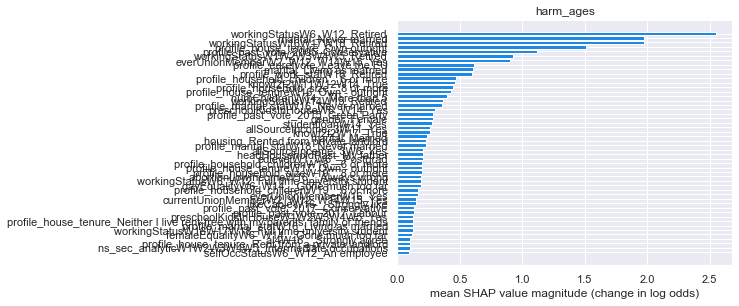

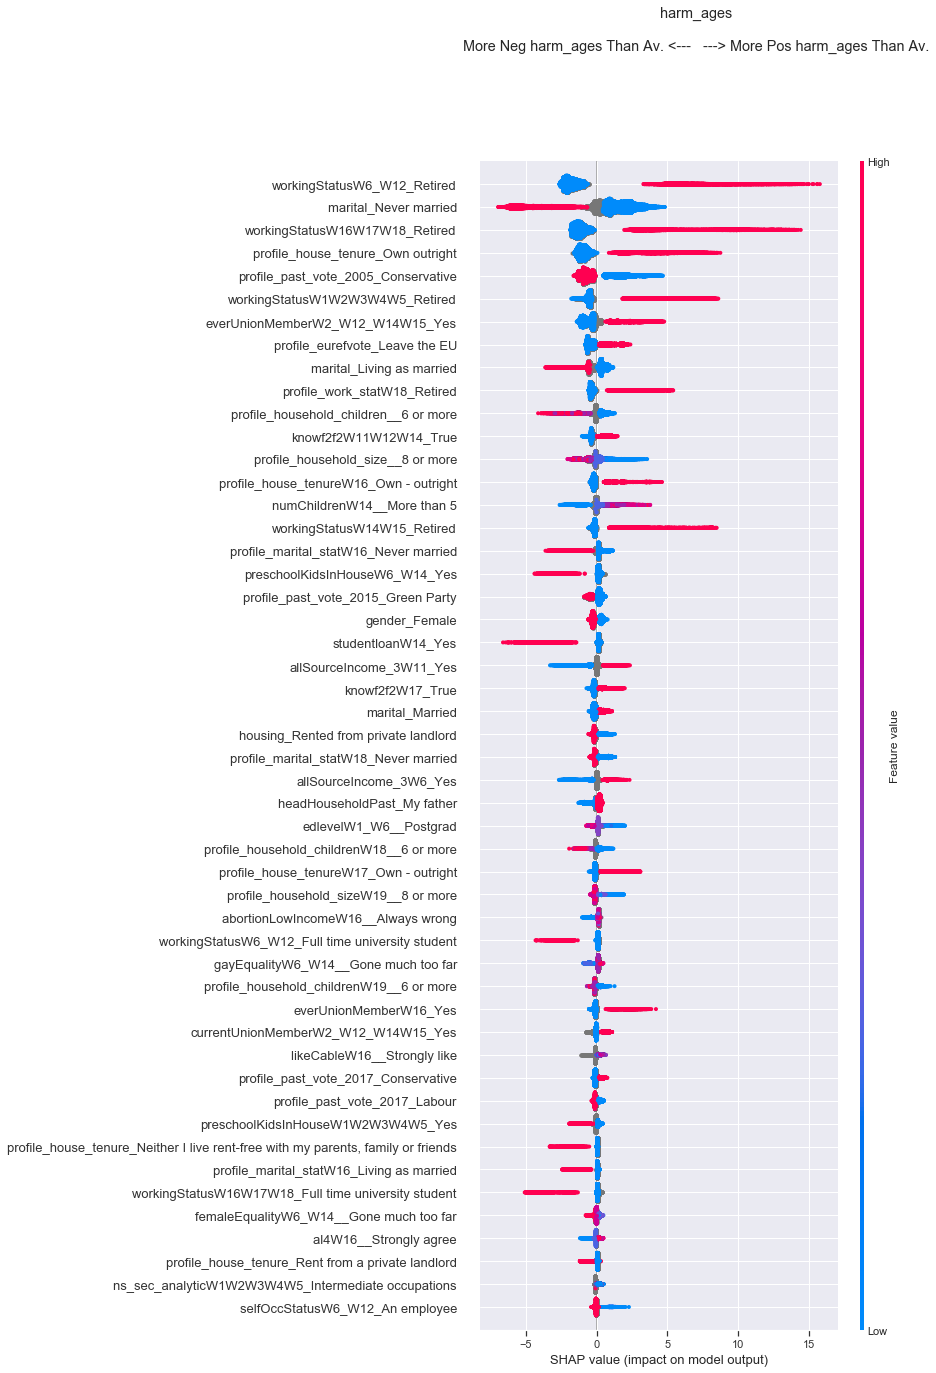

NameError: name 'treatment_dict' is not defined

In [69]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_ages"
var1 = "harm_ages"
BES_reduced_with_na[var1]= Age_at_W1

base = "harm_ages"

# var1 = match(BES_reduced_with_na,base).index[0]

mask = BES_reduced_with_na[var1].notnull()
mask.loc[mask.index[::2]] = False

df = BES_reduced_with_na[mask].astype('float32')

# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub,"age","Age"]



(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [64]:
# %%time
# ## target = D7_8immigEcon
# # wno1 = "8"
# # wno2 = "10"

# base = "redistSelfW1"

# Treatment = base+"with_demog_vars7"


# var1 = match(BES_reduced_with_na,base).index[0]


# mask = BES_reduced_with_na[var1].notnull()
# demog_var = demog_var.replace("edlevel|","")
# demog_var = demog_var.replace("profile_education_age[^W]|","")
# demog_var = demog_var.replace("profile_religion[^W]|","")
# demog_var = demog_var.replace("profile_sexualityW10|sexualityW17|","")
# demog_var = demog_var.replace("ageGroup|","")
# demog_var = demog_var.replace("profile_household_children[^W]|","")
# demog_var = demog_var.replace("Age|","")

# df = BES_reduced_with_na[match(BES_reduced_with_na,demog_var).index][mask].copy()

# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = BES_reduced_with_na[var1][mask]

# var_stub = var1

# var_list = [var_stub]
# var_stub_list = [var_stub]



# (explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
#            title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


In [74]:
mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

df = BES_reduced_with_na[~mask][train_columns].astype('float32')

In [75]:
z_pred = alg.predict(df)
# model.predict(z_test)

In [76]:
z_pred

array([30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 66.83864 , 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 30.078783, 30.078783,
       30.078783, 30.078783, 30.078783, 30.078783, 

In [ ]:
# these look bonkers ... because the data is mostly missing values so these entries will probably never be relevant ... still.

In [81]:
df.isnull().sum(axis=1)

1159     11722
1866     11736
2182     11736
4453     11750
6644     11792
         ...  
96875    11834
96932    11834
97029    11834
97051    11834
97120    11834
Length: 637, dtype: int64

In [82]:
df.shape

(637, 11834)

In [79]:
Age_at_W1.median()

45.0

In [83]:
mask = BES_reduced_with_na[var1].isnull()
BES_reduced_with_na[var1]= Age_at_W1

In [86]:
BES_reduced_with_na[var1][mask] = z_pred

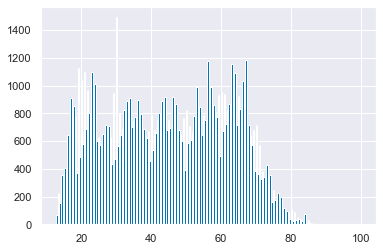

In [89]:
BES_reduced_with_na[var1].hist(bins=200);

In [90]:
BES_reduced_with_na[var1].value_counts()

30.078783    629
23.000000    551
22.000000    544
21.000000    541
24.000000    494
            ... 
37.078847      1
44.415936      1
29.873220      1
26.984664      1
39.403368      1
Name: harm_ages, Length: 42279, dtype: int64

In [91]:
z_pred_all = alg.predict( BES_reduced_with_na[train_columns].astype('float32') )

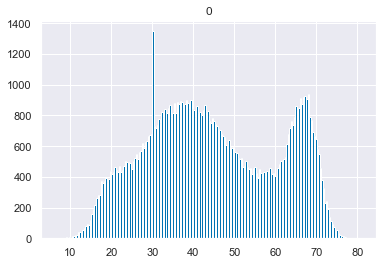

In [93]:
pd.DataFrame(z_pred_all).hist(bins=200);

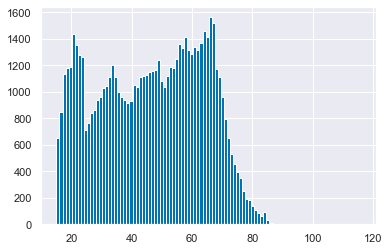

In [95]:
BES_Panel["Age"].hist(bins=100)

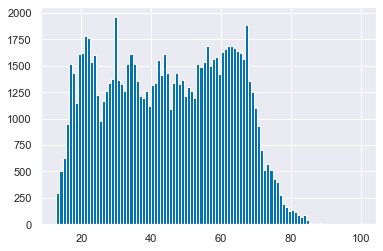

In [96]:
BES_reduced_with_na[var1].hist(bins=100);

In [131]:
Age_at_W1 = ageW_vars_matched.mean(axis=1)

Age_at_W1_missing_values = Age_at_W1.copy()
mask = Age_at_W1.isnull()
Age_at_W1[mask]= z_pred
Age_at_W1.isnull().sum(),Age_at_W1_missing_values.isnull().sum()

Age_at_W1_rounded = Age_at_W1.round()
Age_at_W7 = Age_at_W1 + popt[0]
Age_at_W8 = Age_at_W1 + popt[1]
Age_at_W9 = Age_at_W1 + popt[2]
Age_at_W11 = Age_at_W1 + popt[3]
Age_at_W12 = Age_at_W1 + popt[4]
Age_at_W13 = Age_at_W1 + popt[5]
Age_at_W14 = Age_at_W1 + popt[6]
Age_at_W15 = Age_at_W1 + popt[7]
Age_at_W16 = Age_at_W1 + popt[8]
Age_at_W17 = Age_at_W1 + popt[9]
Age_at_W18 = Age_at_W1 + popt[10]
Age_at_W19 = Age_at_W1 + popt[11]





In [132]:
# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, standard_age_groups, labels = BES_Panel["ageGroup"].cat.categories)
standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
standardAgeGroup_at_W1.value_counts().sort_index()

Under 18     4369
18-25       13840
26-35       16102
36-45       15504
46-55       15352
56-65       18542
66+         13449
dtype: int64

In [152]:
# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, range(10,111,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W1.value_counts().sort_index()

(10, 15]      1443
(15, 20]      8120
(20, 25]      8646
(25, 30]      7867
(30, 35]      8235
(35, 40]      7206
(40, 45]      8298
(45, 50]      7402
(50, 55]      7950
(55, 60]      9091
(60, 65]      9451
(65, 70]      8190
(70, 75]      3484
(75, 80]      1306
(80, 85]       425
(85, 90]        36
(90, 95]         6
(95, 100]        2
(100, 105]       0
(105, 110]       0
dtype: int64

In [134]:
Age_at_W1_rounded.min()

13.0

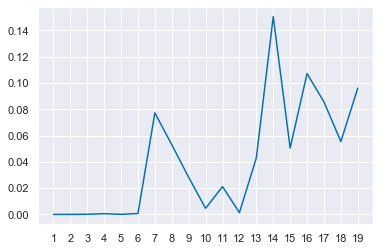

In [135]:
frac_diff_between_emptiest_fullest_bin = []
q_values = range(1,20)
for q in q_values:
    x = pd.qcut(Age_at_W1,q=q, precision=0).value_counts().sort_index()
    (x/x.mean()).max(),(x/x.mean()).min()
    frac_diff_between_emptiest_fullest_bin.append( (x/x.mean()).max() - (x/x.mean()).min() )

plt.plot(q_values,frac_diff_between_emptiest_fullest_bin);
plt.xticks(q_values);
# frac_diff_between_emptiest_fullest_bin

# 8 split is best balance between number of categories and flatness of categories


In [137]:
equalisedAgeGroup_at_W1_detailed = pd.qcut(Age_at_W1,q=12, precision=0)
equalisedAgeGroup_at_W1_detailed.value_counts().sort_index()

(12.0, 20.0]     8097
(20.0, 24.0]     8101
(24.0, 30.0]     8098
(30.0, 34.0]     8090
(34.0, 40.0]     8100
(40.0, 45.0]     8093
(45.0, 50.0]     8096
(50.0, 55.0]     8099
(55.0, 60.0]     8096
(60.0, 64.0]     8101
(64.0, 68.0]     8090
(68.0, 100.0]    8097
dtype: int64

In [136]:
equalisedAgeGroup_at_W1 = pd.qcut(Age_at_W1,q=6, precision=0)
equalisedAgeGroup_at_W1.value_counts().sort_index()

(12.0, 24.0]     16198
(24.0, 34.0]     16188
(34.0, 45.0]     16193
(45.0, 55.0]     16195
(55.0, 64.0]     16197
(64.0, 100.0]    16187
dtype: int64

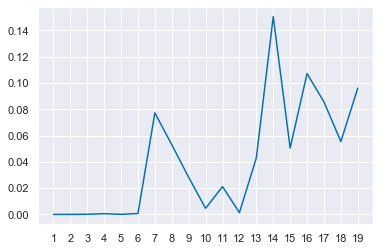

In [143]:
frac_diff_between_emptiest_fullest_bin = []
q_values = range(1,20)
for q in q_values:
    x = pd.qcut(Age_at_W19,q=q, precision=0).value_counts().sort_index()
    (x/x.mean()).max(),(x/x.mean()).min()
    frac_diff_between_emptiest_fullest_bin.append( (x/x.mean()).max() - (x/x.mean()).min() )

plt.plot(q_values,frac_diff_between_emptiest_fullest_bin);
plt.xticks(q_values);
# frac_diff_between_emptiest_fullest_bin

# 8 split is best balance between number of categories and flatness of categories


In [144]:
# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W19 = pd.cut(Age_at_W19, standard_age_groups, labels = BES_Panel["ageGroup"].cat.categories)
standardAgeGroup_at_W19.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
standardAgeGroup_at_W19.value_counts().sort_index()

Under 18        0
18-25        8096
26-35       14402
36-45       14043
46-55       14187
56-65       15325
66+         22550
dtype: int64

In [149]:
# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W19 = pd.cut(Age_at_W19, range(10,111,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W19.value_counts().sort_index()


(10, 15]         0
(15, 20]       895
(20, 25]      7201
(25, 30]      9077
(30, 35]      7026
(35, 40]      8766
(40, 45]      7431
(45, 50]      8163
(50, 55]      7447
(55, 60]      7824
(60, 65]      9014
(65, 70]      9320
(70, 75]      8750
(75, 80]      4087
(80, 85]      1560
(85, 90]       515
(90, 95]        74
(95, 100]        5
(100, 105]       2
(105, 110]       1
dtype: int64

In [153]:
equalisedAgeGroup_at_W19 = pd.qcut(Age_at_W19,q=6, precision=0)
equalisedAgeGroup_at_W19.value_counts().sort_index()

(17.0, 29.0]     16198
(29.0, 40.0]     16188
(40.0, 50.0]     16193
(50.0, 60.0]     16195
(60.0, 69.0]     16197
(69.0, 105.0]    16187
dtype: int64

In [154]:
equalisedAgeGroup_at_W19_detailed = pd.qcut(Age_at_W19,q=12, precision=0)
equalisedAgeGroup_at_W19_detailed.value_counts().sort_index()

(17.0, 25.0]     8097
(25.0, 29.0]     8101
(29.0, 35.0]     8098
(35.0, 40.0]     8090
(40.0, 45.0]     8100
(45.0, 50.0]     8093
(50.0, 55.0]     8096
(55.0, 60.0]     8099
(60.0, 65.0]     8096
(65.0, 69.0]     8101
(69.0, 74.0]     8090
(74.0, 105.0]    8097
dtype: int64

In [155]:
pan_dataset_ages = pd.concat([BES_Panel["id"].astype('int'),
                              Age_at_W1,
                              Age_at_W1_rounded,
                              Age_at_W7,
                              Age_at_W8,
                              Age_at_W9,
                              Age_at_W11,
                              Age_at_W12,
                              Age_at_W13,
                              Age_at_W14,
                              Age_at_W15,
                              Age_at_W16,
                              Age_at_W17,
                              Age_at_W18,
                              Age_at_W19,
                              standardAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1_detailed,
                              equalLengthAgeGroup_at_W1,
                              standardAgeGroup_at_W19,
                              equalisedAgeGroup_at_W19,
                              equalisedAgeGroup_at_W19_detailed,
                              equalLengthAgeGroup_at_W19,                              
                              pd.Series(z_pred_all),Age_at_W1_missing_values]
                              ,axis=1)

pan_dataset_ages.columns = ["id",
                            "Age_at_W1","Age_at_W1_rounded","Age_at_W7","Age_at_W8","Age_at_W9",
                            "Age_at_W11","Age_at_W12","Age_at_W13","Age_at_W14",
                            "Age_at_W15","Age_at_W16","Age_at_W17","Age_at_W18","Age_at_W19",
                            "standardAgeGroup_at_W1","equalisedAgeGroup_at_W1",
                            "equalisedAgeGroup_at_W1_detailed","equalLengthAgeGroup_at_W1",
                            "standardAgeGroup_at_W19","equalisedAgeGroup_at_W19",
                            "equalisedAgeGroup_at_W19_detailed","equalLengthAgeGroup_at_W19",
                            "rough_predictions","Age_at_W1_missing_values"]
pan_dataset_ages["Age_at_W1_rounded"] = pan_dataset_ages["Age_at_W1_rounded"].astype('int8')

# pan_dataset_ages["id"] = BES_Panel["id"].astype('int')

# pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)
# pan_dataset_ages.to_msgpack(BES_small_data_files + "pan_dataset_ages"+".msgpack")

In [140]:
pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)

In [141]:
pan_dataset_ages.to_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')

In [156]:
pan_dataset_ages

,id,Age_at_W1,Age_at_W1_rounded,Age_at_W7,Age_at_W8,Age_at_W9,Age_at_W11,Age_at_W12,Age_at_W13,Age_at_W14,...,standardAgeGroup_at_W1,equalisedAgeGroup_at_W1,equalisedAgeGroup_at_W1_detailed,equalLengthAgeGroup_at_W1,standardAgeGroup_at_W19,equalisedAgeGroup_at_W19,equalisedAgeGroup_at_W19_detailed,equalLengthAgeGroup_at_W19,rough_predictions,Age_at_W1_missing_values
0,16208,60.413227,60,62.214989,62.297593,62.357362,62.721667,62.968143,63.054837,63.993884,...,56-65,"(55.0, 64.0]","(60.0, 64.0]","(55, 60]",NaN,"(60.0, 69.0]","(65.0, 69.0]","(65, 70]",63.013264,60.413227
1,16546,58.251871,58,60.053632,60.136236,60.196005,60.560310,60.806786,60.893481,61.832527,...,56-65,"(55.0, 64.0]","(55.0, 60.0]","(55, 60]",56-65,"(60.0, 69.0]","(60.0, 65.0]","(60, 65]",62.523399,58.251871
2,66250,67.617856,68,69.419617,69.502222,69.561991,69.926295,70.172772,70.259466,71.198512,...,66+,"(64.0, 100.0]","(64.0, 68.0]","(65, 70]",66+,"(69.0, 105.0]","(69.0, 74.0]","(70, 75]",66.589882,67.617856
3,32741,53.445014,53,55.246775,55.329380,55.389149,55.753453,55.999930,56.086624,57.025670,...,46-55,"(45.0, 55.0]","(50.0, 55.0]","(50, 55]",56-65,"(50.0, 60.0]","(55.0, 60.0]","(55, 60]",48.161797,53.445014
4,70863,64.153401,64,65.955163,66.037767,66.097536,66.461841,66.708317,66.795011,67.734058,...,56-65,"(64.0, 100.0]","(64.0, 68.0]","(60, 65]",66+,"(69.0, 105.0]","(69.0, 74.0]","(65, 70]",54.507549,64.153401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,1306,32.000000,32,33.801761,33.884366,33.944135,34.308439,34.554916,34.641610,35.580656,...,26-35,"(24.0, 34.0]","(30.0, 34.0]","(30, 35]",36-45,"(29.0, 40.0]","(35.0, 40.0]","(35, 40]",43.433151,32.000000
97154,40381,44.092435,44,45.894196,45.976800,46.036569,46.400874,46.647350,46.734044,47.673091,...,36-45,"(34.0, 45.0]","(40.0, 45.0]","(40, 45]",46-55,"(40.0, 50.0]","(45.0, 50.0]","(45, 50]",41.919456,44.092435
97155,54315,17.271241,17,19.073002,19.155607,19.215375,19.579680,19.826156,19.912851,20.851897,...,Under 18,"(12.0, 24.0]","(12.0, 20.0]","(15, 20]",18-25,"(17.0, 29.0]","(17.0, 25.0]","(20, 25]",18.067436,17.271241
97156,26708,33.000000,33,34.801761,34.884366,34.944135,35.308439,35.554916,35.641610,36.580656,...,26-35,"(24.0, 34.0]","(30.0, 34.0]","(30, 35]",36-45,"(29.0, 40.0]","(35.0, 40.0]","(35, 40]",40.060276,33.000000


In [163]:
(pan_dataset_ages["Age_at_W7"]<18).sum()

2289

In [158]:
BES_file_manifest

,Name,BES_Title,BES_Url,Wave No,Only_or_Combined,Base_or_Strings,Mode,Version,Stata_Filename,Stata_Url,SPSS_Url,Ques_Url,N,Date_Start,Date_Stop,Description,Citation,Friendlier_Description
0,W19_only,Wave 19 of the 2014-2023 British Election Stud...,https://www.britishelectionstudy.com/data-obje...,19,Only,Base,Online Survey,0.1,BES2019_W19_v0.1.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,32177,Dec-19,Dec-19,December 2019 (post-2019 election) wave of the...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 GE: Post-Election
1,W19_comb,British Election Study Combined Wave 1-19 Inte...,https://www.britishelectionstudy.com/data-obje...,19,Combined,Base,Online Survey,0.1,BES2019_W19_Panel_v0.1.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,British Election Study Combined Wave 1-19 Inte...,97158,Feb-14,Dec-19,A panel dataset including waves 1-19 of the BE...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 GE: Post-Election
2,W19_comb_strings,British Election Study Combined Wave 1-19 Inte...,https://www.britishelectionstudy.com/data-obje...,19,Combined,Strings,Online Survey,0.2,BES2019_W19Strings_v0.2.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,97158,Feb-14,Dec-19,A dataset containing the data from open ended ...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 GE: Post-Election
3,W18_only,Wave 18 of the 2014-2023 British Election Stud...,https://www.britishelectionstudy.com/data-obje...,18,Only,Base,Online Survey,0.1,BES2019_W18_v0.1.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,37825,Nov-19,Dec-19,November-December 2019 (2019 campaign) wave of...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 GE: Campaign
4,W17_only,Wave 17 of the 2014-2023 British Election Stud...,https://www.britishelectionstudy.com/data-obje...,17,Only,Base,Online Survey,0.1,BES2019_W17_v0.1.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,34366,Nov-19,Nov-19,November 2019 (pre-2019 election) wave of the ...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 GE: Pre-Campaign
5,W16_only,Wave 16 of the 2014-2019 British Election Stud...,https://www.britishelectionstudy.com/data-obje...,16,Only,Base,Online Survey,0.2,BES2019_W16_v0.2.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,37959,May-19,Jun-19,May-June 2019 wave of the 2014-2019 British El...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 : Post Euro Elections
6,W16_comb,British Election Study Combined Wave 1-16 Inte...,https://www.britishelectionstudy.com/data-obje...,16,Combined,Base,Online Survey,0.3,BES2019_W16_Panel_v0.3.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,92587,Feb-14,Jun-19,"A panel dataset including waves 1, 2, 3, 4, 5,...","Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 : Post Euro Elections
7,W16_comb_strings,British Election Study Combined Wave 1-16 Inte...,https://www.britishelectionstudy.com/data-obje...,16,Combined,Strings,Online Survey,0.2,BES2019_W16Strings_v0.2.dta,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,https://www.britishelectionstudy.com/wp-conten...,92587,Feb-14,Jun-19,A dataset containing the data from open ended ...,"Fieldhouse, E., J. Green, G. Evans, J. Mellon ...",2019 : Post Euro Elections
8,W15_only,Wave 15 of the 2014-2019 British Election Stud...,https://www.bri